makemore: multilayer perceptron
===
# part 3


## preparation 

In [97]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [99]:
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi.update({'.': 0})
itos = {i:s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [100]:
block_size = 3


def build_dataset(name_list):
    '''
    Dataset consists of input tensor X and label tensor Y. 
    Input tensor contains three numerically encoded characters (independent of the name it originates from).
    Label tensor carries the respective following character (also encoded).
    '''
    X, Y = [], []
    for name in name_list:
        context = [0] * block_size
        for ch in name + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(12219195)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

## creating model

In [111]:
g = torch.Generator().manual_seed(12219195)

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.training = True
        self.eps = eps
        self.momentum = momentum
        # parameters
        self.gain = torch.ones(dim)
        self.bias = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gain * xhat + self.bias
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gain, self.bias]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


In [129]:
n_emb = 10
n_hidden = 100

C = torch.randn((vocab_size, n_emb), generator=g)
layers = [
    Linear(n_emb * block_size, n_hidden), Tanh(),  # BatchNorm1d(n_hidden)
    Linear(n_hidden, n_hidden), Tanh(), # BatchNorm1d(n_hidden)
    Linear(n_hidden, n_hidden), Tanh(), # BatchNorm1d(n_hidden)
    Linear(n_hidden, n_hidden), Tanh(), # BatchNorm1d(n_hidden)
    Linear(n_hidden, n_hidden), Tanh(), # BatchNorm1d(n_hidden)
    Linear(n_hidden, vocab_size), #BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [130]:
max_steps = 1000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # batch forming
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    # if i > 1000: break

print(loss.item())


      0/   1000: 3.2882
2.572570562362671


## plotting

                       | tanh mean | tanh std | output > 0.97
-----------------------------------------------------------------
layer   1 (      Tanh): mean -0.04, std 0.748, saturated: 19.00%
layer   3 (      Tanh): mean -0.03, std 0.715, saturated: 10.84%
layer   5 (      Tanh): mean -0.00, std 0.728, saturated: 11.16%
layer   7 (      Tanh): mean -0.00, std 0.737, saturated: 13.66%
layer   9 (      Tanh): mean -0.05, std 0.710, saturated: 10.47%


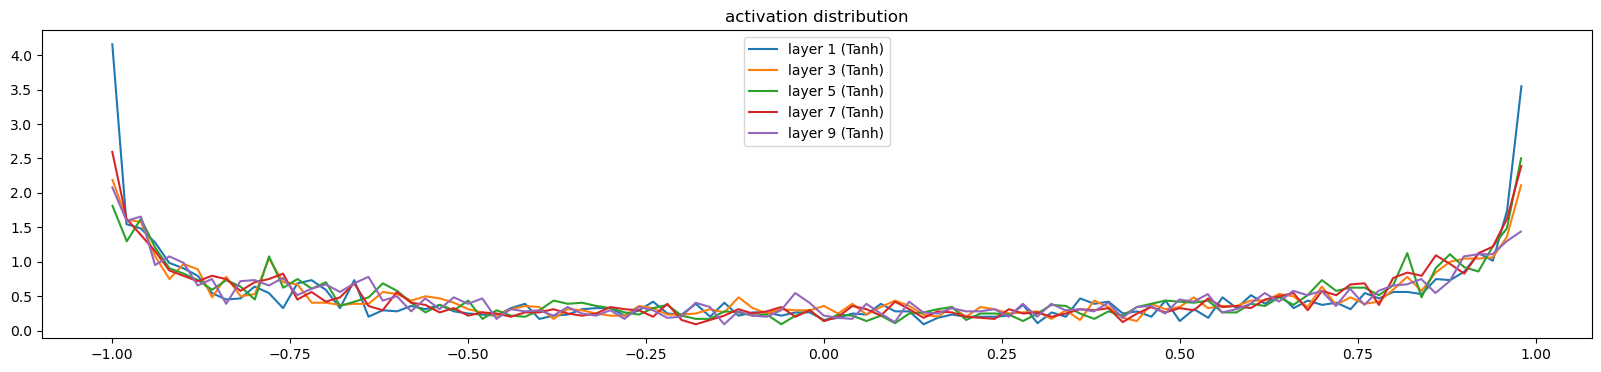

In [131]:
plt.figure(figsize=(20,4))
legends = []
print(' '*22 + ' | '.join(['','tanh mean', 'tanh std', 'output > 0.97']))
print('-'*65)
for i,layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %3d (%10s): mean %+.2f, std %.3f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')
plt.show()

Tanh                   | gradient mean | gradient std
-----------------------------------------------------
layer   1 (      Tanh): mean -0.000027, std 0.003067
layer   3 (      Tanh): mean +0.000022, std 0.002876
layer   5 (      Tanh): mean +0.000014, std 0.002844
layer   7 (      Tanh): mean +0.000012, std 0.002735
layer   9 (      Tanh): mean -0.000058, std 0.002303


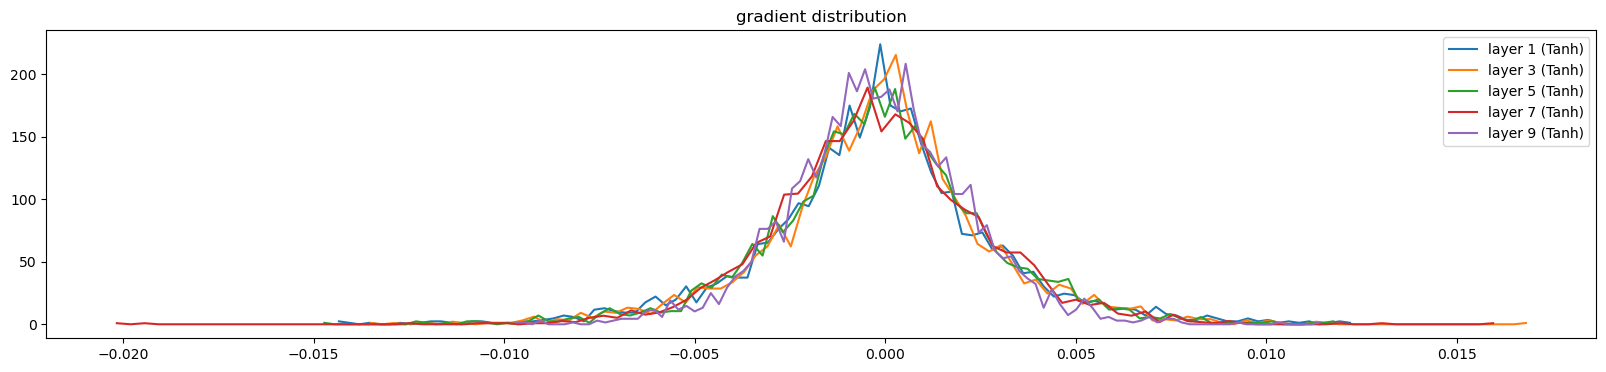

In [132]:
plt.figure(figsize=(20,4))
legends = []
print('Tanh' + ' '*18 + ' | '.join(['','gradient mean', 'gradient std']))
print('-'*53)
for i,layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %3d (%10s): mean %+.6f, std %.6f' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')
plt.show()


weights           | gradient mean  | gradient std     | gradient to data ratio 
-------------------------------------------------------------------------------------
weight   (27, 10) | mean -0.000751 | std 1.062118e-02 | grad:data ratio 1.040341e-02
weight  (30, 100) | mean -0.000018 | std 9.324836e-03 | grad:data ratio 3.065812e-02
weight (100, 100) | mean +0.000109 | std 7.193657e-03 | grad:data ratio 4.296651e-02
weight (100, 100) | mean -0.000026 | std 6.330971e-03 | grad:data ratio 3.751160e-02
weight (100, 100) | mean -0.000004 | std 5.904964e-03 | grad:data ratio 3.502164e-02
weight (100, 100) | mean -0.000030 | std 5.291319e-03 | grad:data ratio 3.161843e-02
weight  (100, 27) | mean -0.000000 | std 2.342755e-02 | grad:data ratio 3.310860e-01


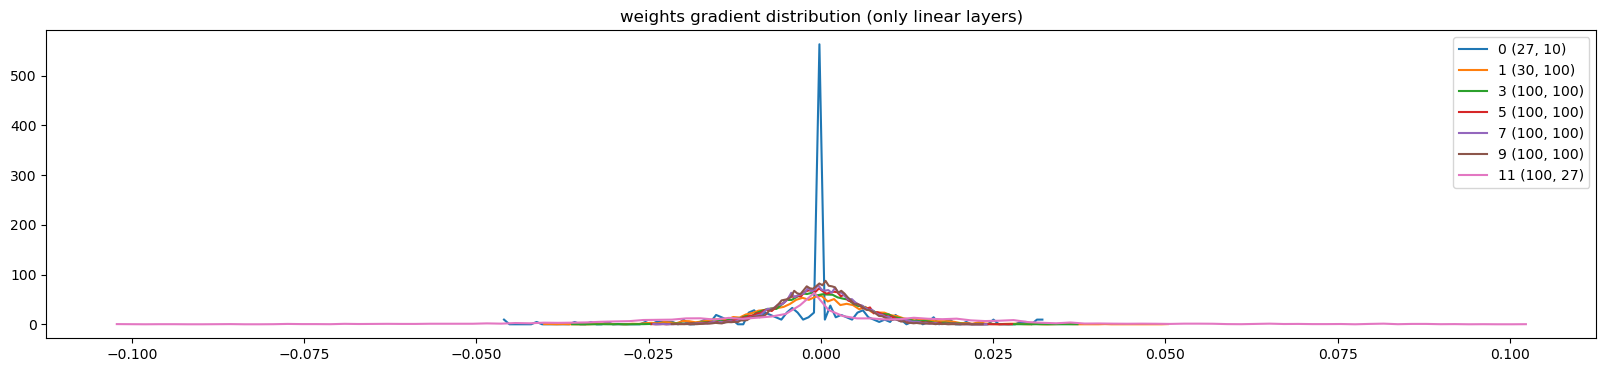

In [133]:
plt.figure(figsize=(20,4))
legends = []
print(' | '.join(['weights          ', 'gradient mean ', 'gradient std    ', 'gradient to data ratio ']))
print('-'*85)
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution (only linear layers)')
plt.show()


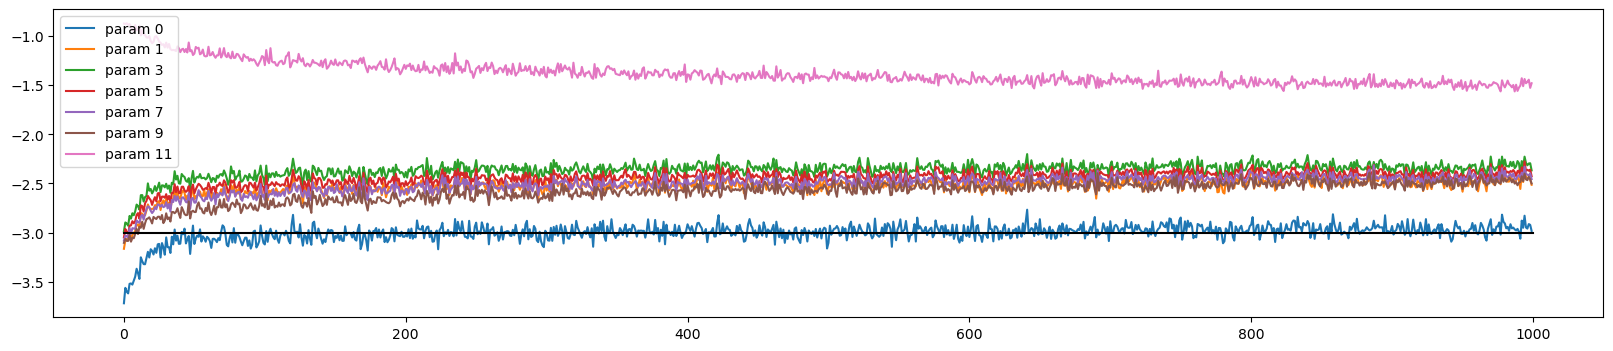

In [134]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0,len(ud)], [-3, -3], 'k')
plt.legend(legends)
plt.show()